In [1]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark >& /dev/null 

# Download the data files from github
# If the data file does not exist in the colab environment
data_file_1=train.csv
#data_file_2=test.csv

if [[ ! -f ./${data_file_1} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/Angatang/BDA_Project/c87573c27c13a6587520103a4ad53d64c3c35907/train.csv >& /dev/null 
fi

if [[ ! -f ./${data_file_2} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/Angatang/BDA_Project/c87573c27c13a6587520103a4ad53d64c3c35907/test.csv >& /dev/null 
fi

In [2]:
enable_grid = False

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
import numpy as np
import pandas as pd
import os
from pyspark.ml import feature, regression, evaluation, Pipeline, classification
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.sql.functions import when
from pyspark.sql.types import DoubleType, IntegerType
spark = SparkSession.builder \
    .master('local[*]') \
    .getOrCreate()
sc = spark.sparkContext
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [4]:
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [5]:
df = spark.read.csv('train.csv', header=True, inferSchema=True)
#test = spark.read.csv('test.csv', header=True, inferSchema=True)

In [6]:
df = df.select(['Month', 'Credit_Score', 'Age', 'Occupation', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Credit_Mix', 'Outstanding_Debt','Credit_Utilization_Ratio', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Total_EMI_per_month',
                'Amount_invested_monthly','Payment_Behaviour', 'Monthly_Balance'])            
df.show()

+-----+------------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+------------------+
|Month|Credit_Score| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|
+-----+------------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------

##DATA STRATIFICATION

###AGE BASED STRATIFICATION

In [7]:
age_median = df.approxQuantile('Age',[0.5], 0.1)
strat_age_df = df.withColumn('Strat_Age', when((df.Age <= age_median[0]), (0)).otherwise(1))

above_median_age_df = strat_age_df.filter(strat_age_df["Strat_Age"] == 1).drop("Strat_Age")
above_median_age_df.show()

below_median_age_df = strat_age_df.filter(strat_age_df["Strat_Age"] == 0).drop("Strat_Age").drop("Month")
below_median_age_df.show()

+-----+------------+----+------------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+------------------+
|Month|Credit_Score| Age|  Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|
+-----+------------+----+------------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------

In [8]:
age_median

[30.0]

###STRATIFICAITON BASED ON ANNUAL INCOME

In [9]:
annual_inc_median = df.approxQuantile('Annual_Income',[0.5], 0.1)
strat_ann_inc_df = df.withColumn('Strat_Annual_Income', when((df.Annual_Income <= annual_inc_median[0]), (0)).otherwise(1))

above_median_income_df = strat_ann_inc_df.filter(strat_ann_inc_df["Strat_Annual_Income"] == 1).drop("Strat_Annual_Income").drop("Type_of_Loan")
above_median_income_df.show()

below_median_income_df = strat_ann_inc_df.filter(strat_ann_inc_df["Strat_Annual_Income"] == 0).drop("Strat_Annual_Income").drop("Type_of_Loan")
below_median_income_df.show()

+-----+------------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+------------------+
|Month|Credit_Score| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|
+-----+------------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+------------

In [10]:
annual_inc_median

[31429.81]

##DATA EXPLORATION

In [11]:
print('Shape of data set:', df.count(), len(df.columns))
#print('Shape of test set:', test.count(), len(test.columns))

Shape of data set: 100000 24


In [12]:
### flag or check Duplicate rows in pyspark
 
import pyspark.sql.functions as f
x = df.join(
    df.groupBy(df.columns).agg((f.count("*")>1).cast("int").alias("Duplicate_indicator")),
    on=df.columns,
    how="inner"
)

In [13]:
x.show()

+-----+------------+----+-------------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+------------------+-------------------+
|Month|Credit_Score| Age|   Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Duplicate_indicator|
+-----+------------+----+-------------+-------------+---------------------+-----------------+---------------+-----------

In [14]:
#0 - no duplicate
#1 - duplicate

In [15]:
#no duplicates
x.groupBy('Duplicate_indicator').count().show()

+-------------------+------+
|Duplicate_indicator| count|
+-------------------+------+
|                  0|100000|
+-------------------+------+



In [16]:
#drop columns
cols = ('ID', 'Customer_ID', 'Name', 'SSN')
df = df.drop(*cols)

In [17]:
df.show()

+-----+------------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+------------------+
|Month|Credit_Score| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|
+-----+------------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------

In [18]:
df.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- Credit_Score: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: double (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: double (nullable = true)
 |-- Num_Credit_Card: double (nullable = true)
 |-- Interest_Rate: double (nullable = true)
 |-- Num_of_Loan: double (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: double (nullable = true)
 |-- Num_of_Delayed_Payment: double (nullable = true)
 |-- Changed_Credit_Limit: double (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: double (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: double (nullable = true)
 |-- Payment_of_Min_Amount: string (nullable = true)
 |-- Total_EMI_per_month: double (nullable = true)
 

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from matplotlib.pyplot import figure
import os
import plotly.express as px
import plotly.graph_objs as go
import collections
from collections import defaultdict
from pyspark.mllib.random import RandomRDDs

In [20]:
# trainpd_df = df.toPandas()
# trainpd_df.head(5)

In [21]:
# trainpd_df.info()

In [22]:
# trainpd_df.isna().sum()

In [23]:
from pyspark.sql.functions import when
newdf2 = df.withColumn("Credit_Score_Index", when(df.Credit_Score == "Poor",1)
                                 .when(df.Credit_Score == "Standard",2)
                                 .otherwise(3))
newdf2.show(5)


+-----+------------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------------+
|Month|Credit_Score| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score_Index|
+-----+------------+----+----------+-------------+---------------------+-----------------+---------------+-------------+--------

In [24]:
trainpd_df = newdf2.toPandas()
trainpd_df.head()

,Month,Credit_Score,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score_Index
0,1,Good,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,3
1,2,Good,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,3
2,3,Good,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,3
3,4,Good,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,3
4,5,Good,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,4.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,3


In [25]:
# plot = trainpd_df.plot.pie(y='Credit_Score_Index', figsize=(5, 5))

In [26]:
# trainpd_df["Credit_Score"] = trainpd_df["Credit_Score"].astype("int")

In [27]:
# trainpd_df['Credit_Score_Index'].value_counts()

In [28]:
# trainpd_df.to_csv(r'C:\Users\HOME\Desktop\export_dataframe.csv', index=False)

####VISUALISATION

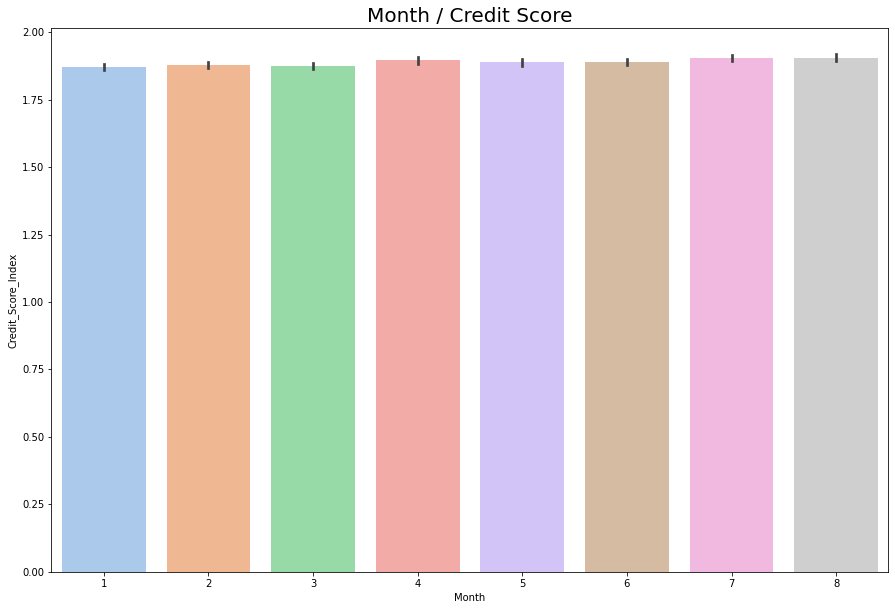

In [29]:
plt.figure(figsize=(15,10))
sns.set_palette("pastel")
plt.title("Month / Credit Score", fontsize=20)
sns.barplot(x="Month", y="Credit_Score_Index", data=trainpd_df)
plt.show()

In [30]:
age_range = [i // 10 for i in trainpd_df["Age"]]
trainpd_df["Age_Range"] = age_range

In [31]:
trainpd_df["Age_Range"].value_counts()

3.0    29080
2.0    28819
4.0    22396
1.0    11170
5.0     8535
Name: Age_Range, dtype: int64

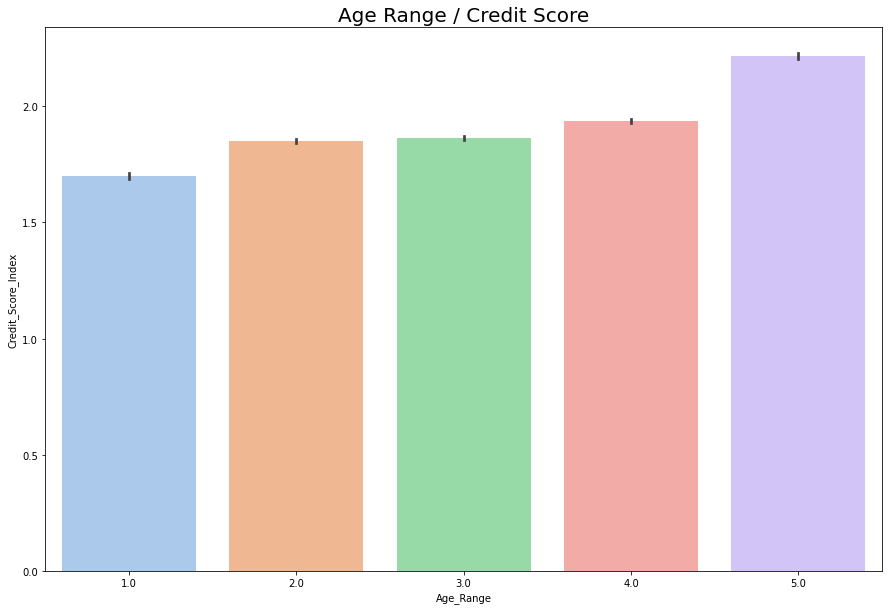

In [32]:
plt.figure(figsize=(15,10))
sns.barplot(x="Age_Range", y="Credit_Score_Index", data=trainpd_df)
plt.title("Age Range / Credit Score", fontsize=20)
plt.show()

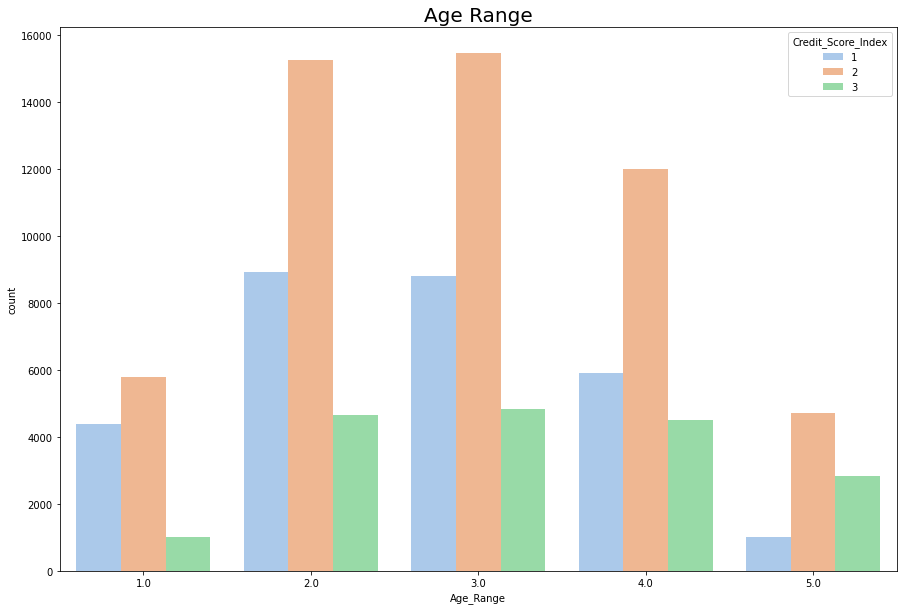

In [33]:
plt.figure(figsize=(15,10))
sns.countplot(x="Age_Range", hue="Credit_Score_Index", data=trainpd_df)
plt.title("Age Range", fontsize=20)
plt.show()

In [34]:
trainpd_df["Occupation"].value_counts()

Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6720
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
Name: Occupation, dtype: int64

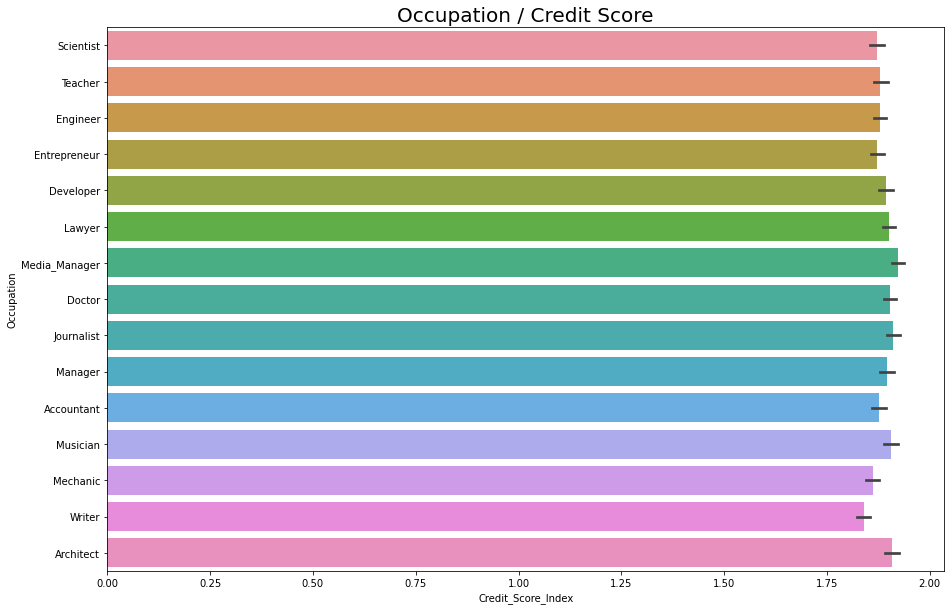

In [35]:
plt.figure(figsize=(15,10))
sns.barplot(x="Credit_Score_Index", y="Occupation", data=trainpd_df)
plt.title("Occupation / Credit Score", fontsize=20)
plt.show()

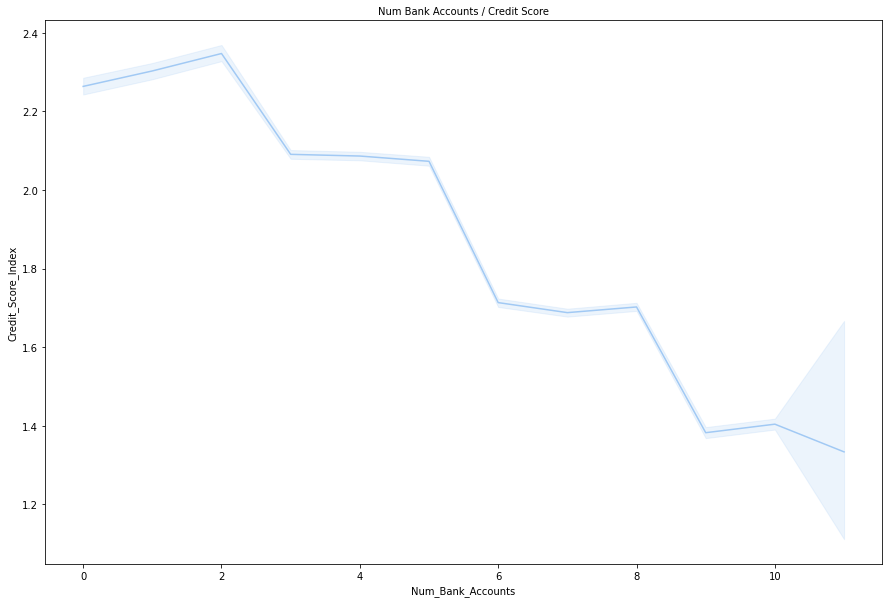

In [36]:
plt.figure(figsize=(15,10))
sns.lineplot(x="Num_Bank_Accounts", y="Credit_Score_Index", data=trainpd_df)
plt.title("Num Bank Accounts / Credit Score", fontsize=10)
plt.show()

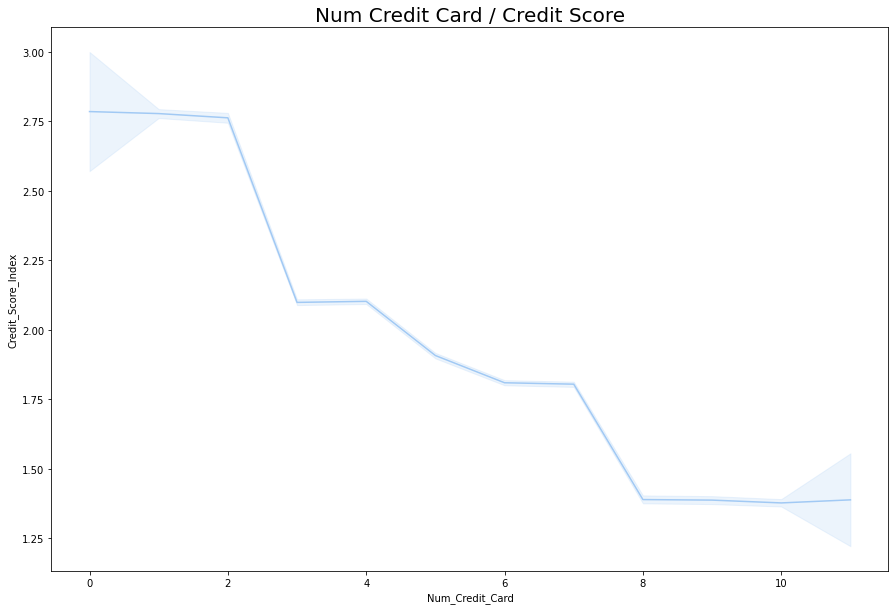

In [37]:
plt.figure(figsize=(15,10))
sns.lineplot(x="Num_Credit_Card", y="Credit_Score_Index", data=trainpd_df)
plt.title("Num Credit Card / Credit Score", fontsize=20)
plt.show()

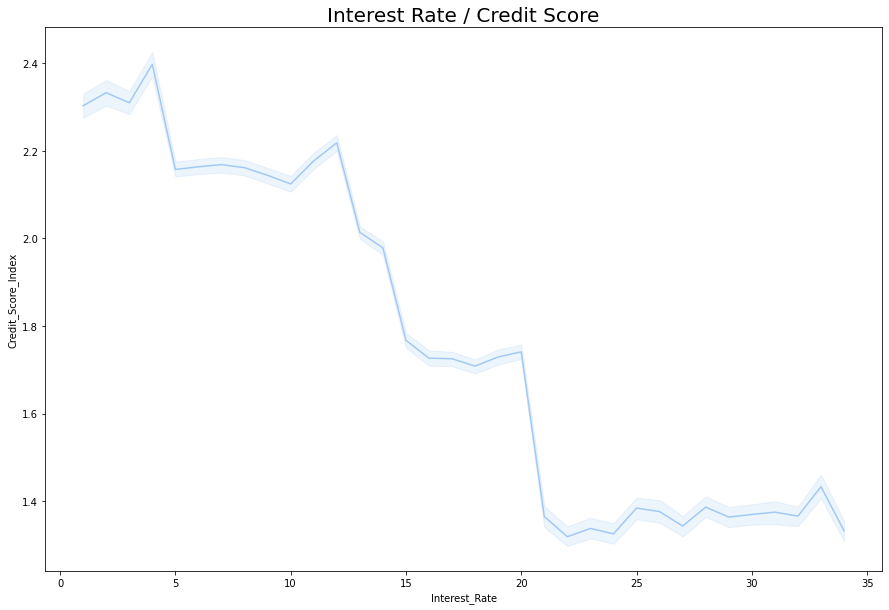

In [38]:
plt.figure(figsize=(15,10))
sns.lineplot(x="Interest_Rate", y="Credit_Score_Index", data=trainpd_df)
plt.title("Interest Rate / Credit Score", fontsize=20)
plt.show()

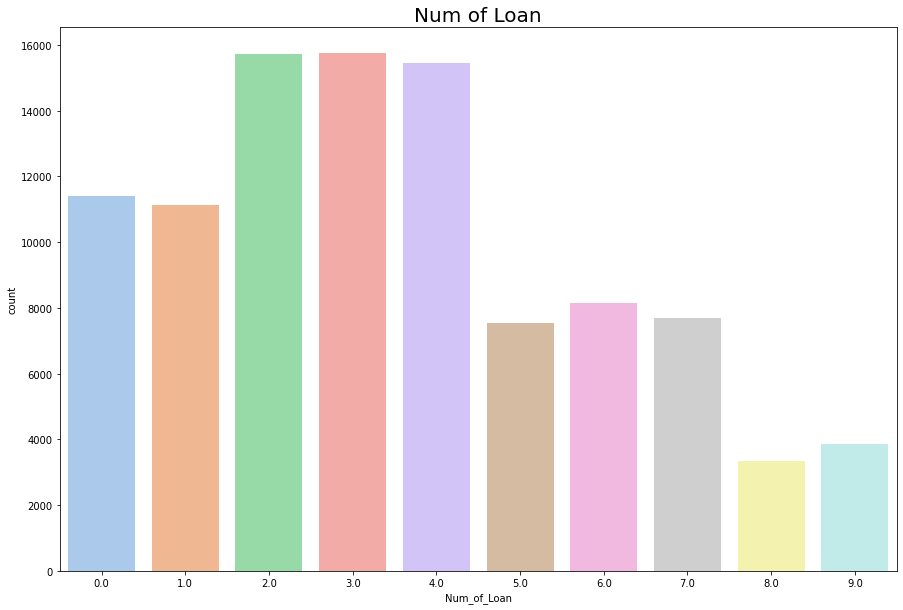

In [39]:
plt.figure(figsize=(15,10))
sns.countplot(x="Num_of_Loan", data=trainpd_df)
plt.title("Num of Loan", fontsize=20)
plt.show()

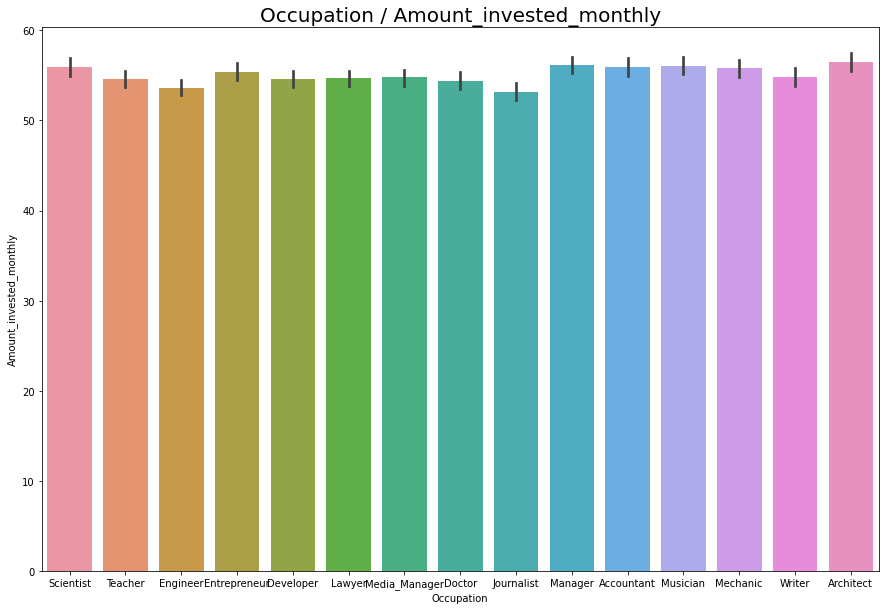

In [40]:
plt.figure(figsize=(15,10))
sns.barplot(y="Amount_invested_monthly", x="Occupation", data=trainpd_df)
plt.title("Occupation / Amount_invested_monthly", fontsize=20)
plt.show()

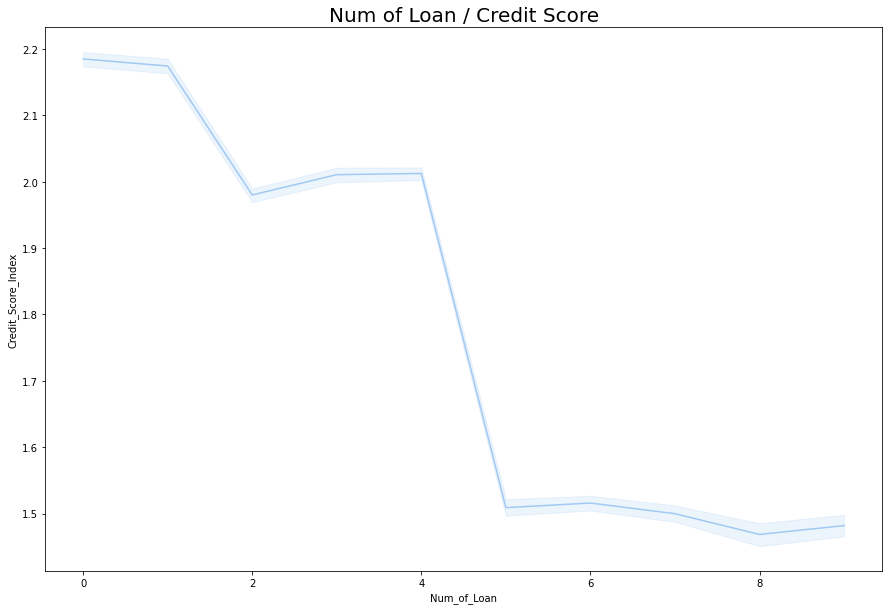

In [41]:
plt.figure(figsize=(15,10))
sns.lineplot(x="Num_of_Loan", y="Credit_Score_Index", data=trainpd_df)
plt.title("Num of Loan / Credit Score", fontsize=20)
plt.show()

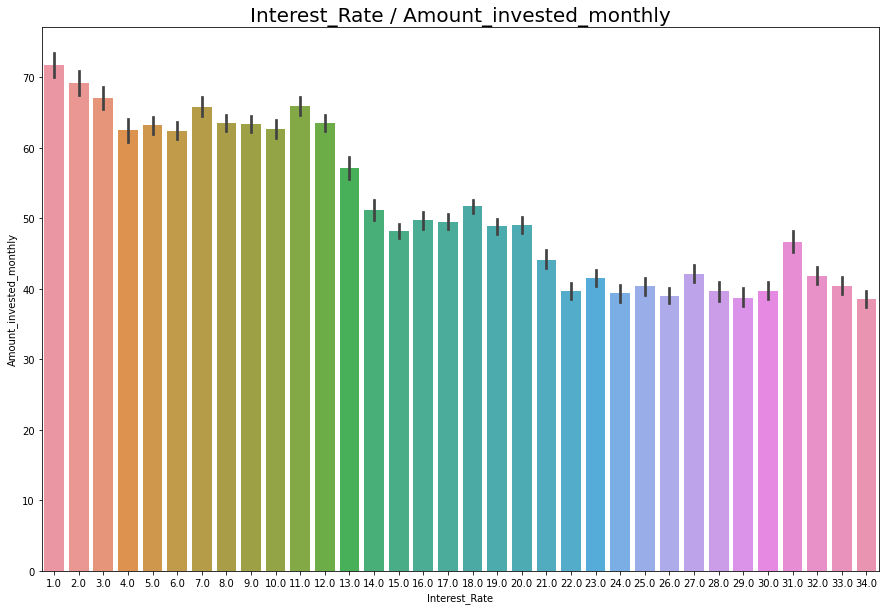

In [42]:
plt.figure(figsize=(15,10))
sns.barplot(y="Amount_invested_monthly", x="Interest_Rate", data=trainpd_df)
plt.title("Interest_Rate / Amount_invested_monthly", fontsize=20)
plt.show()

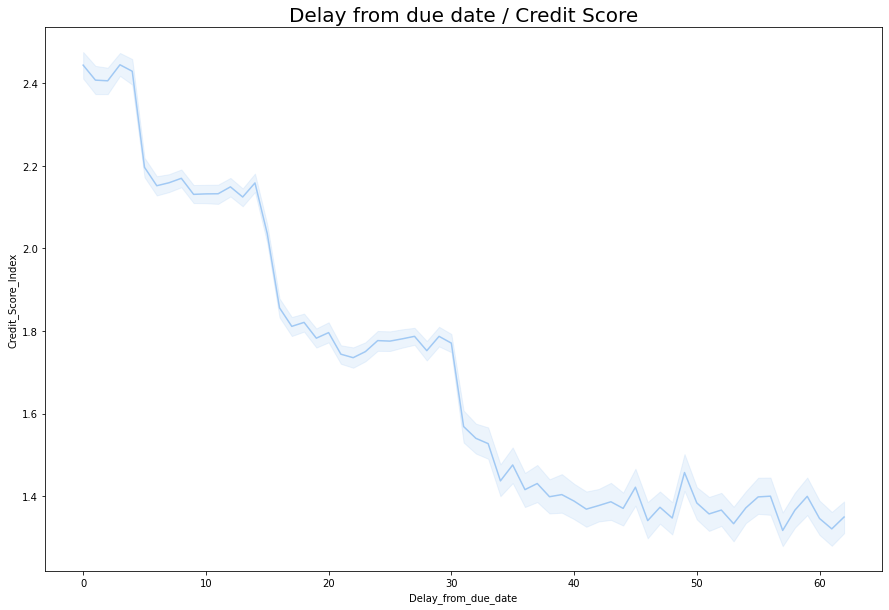

In [43]:
plt.figure(figsize=(15,10))
sns.lineplot(x="Delay_from_due_date", y="Credit_Score_Index", data=trainpd_df)
plt.title("Delay from due date / Credit Score", fontsize=20)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


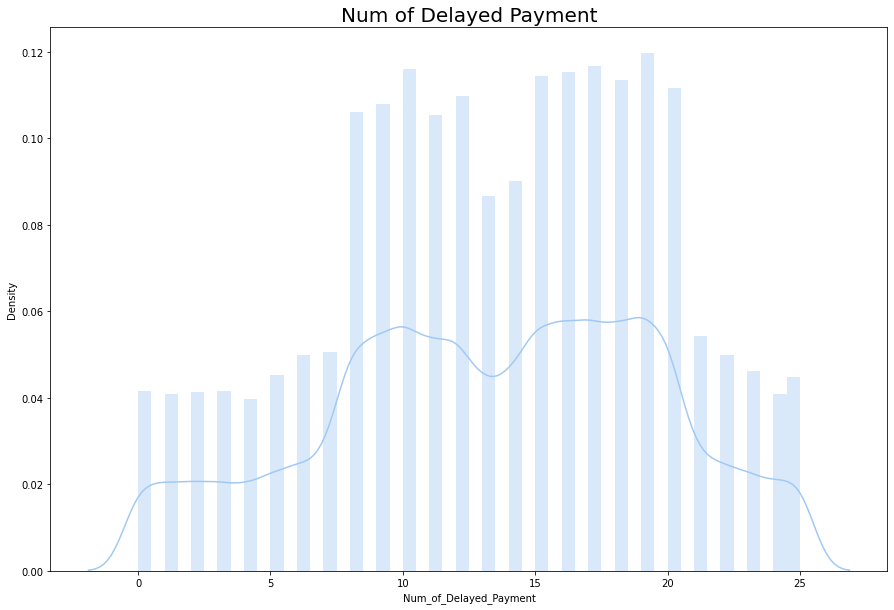

In [44]:
plt.figure(figsize=(15,10))
sns.distplot(trainpd_df["Num_of_Delayed_Payment"])
plt.title("Num of Delayed Payment", fontsize=20)
plt.show()

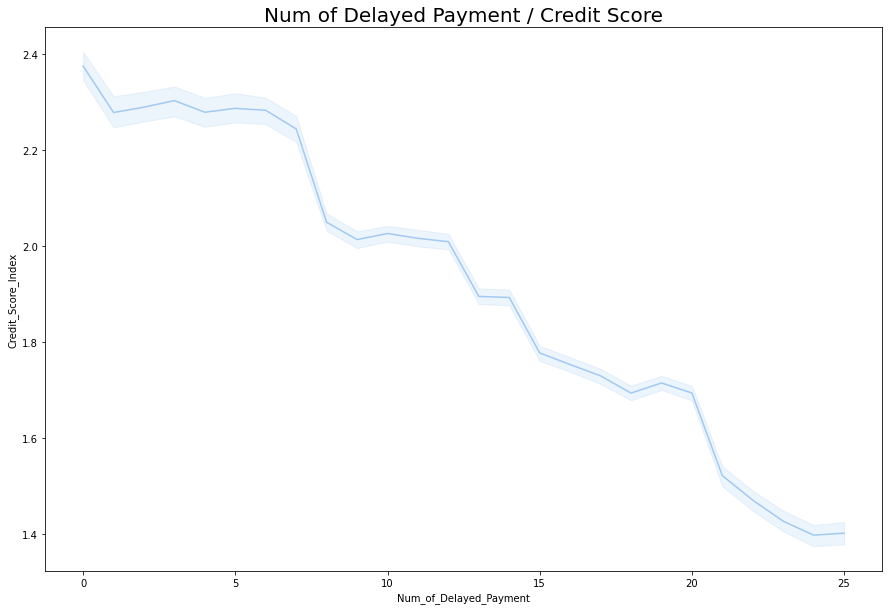

In [45]:
plt.figure(figsize=(15,10))
sns.lineplot(x="Num_of_Delayed_Payment", y="Credit_Score_Index", data=trainpd_df)
plt.title("Num of Delayed Payment / Credit Score", fontsize=20)
plt.show()

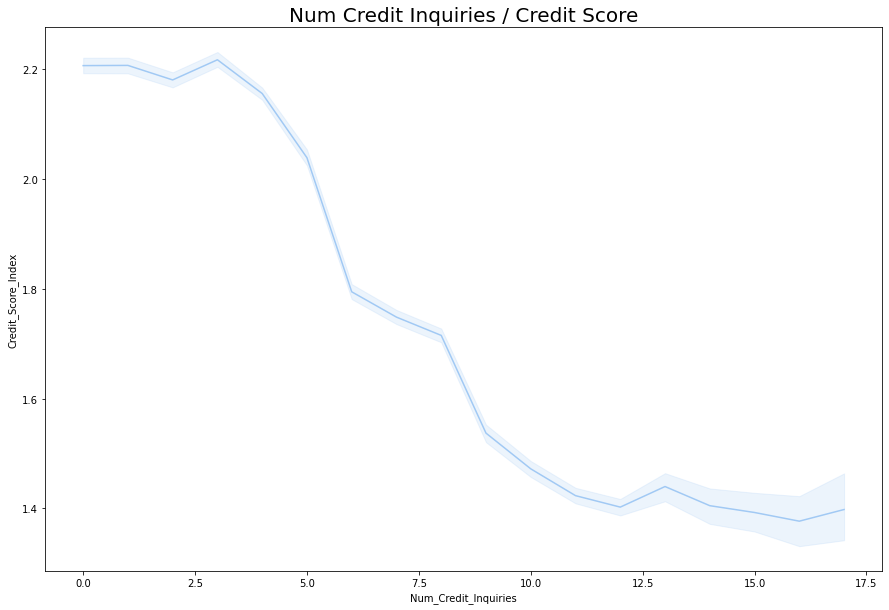

In [46]:
plt.figure(figsize=(15,10))
sns.lineplot(x="Num_Credit_Inquiries", y="Credit_Score_Index", data=trainpd_df)
plt.title("Num Credit Inquiries / Credit Score", fontsize=20)
plt.show()

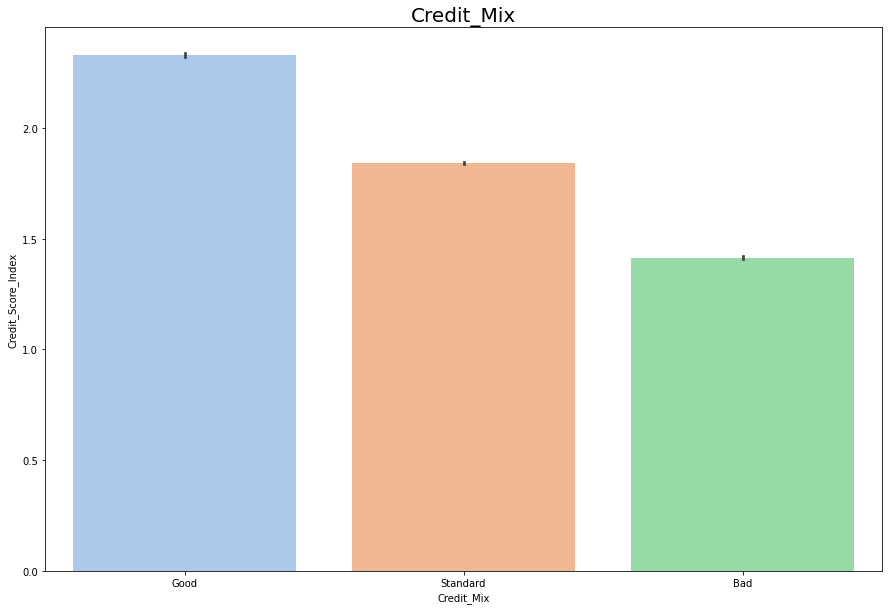

In [47]:
plt.figure(figsize=(15,10))
sns.barplot(x="Credit_Mix", y="Credit_Score_Index", data=trainpd_df)
plt.title("Credit_Mix", fontsize=20)
plt.show()

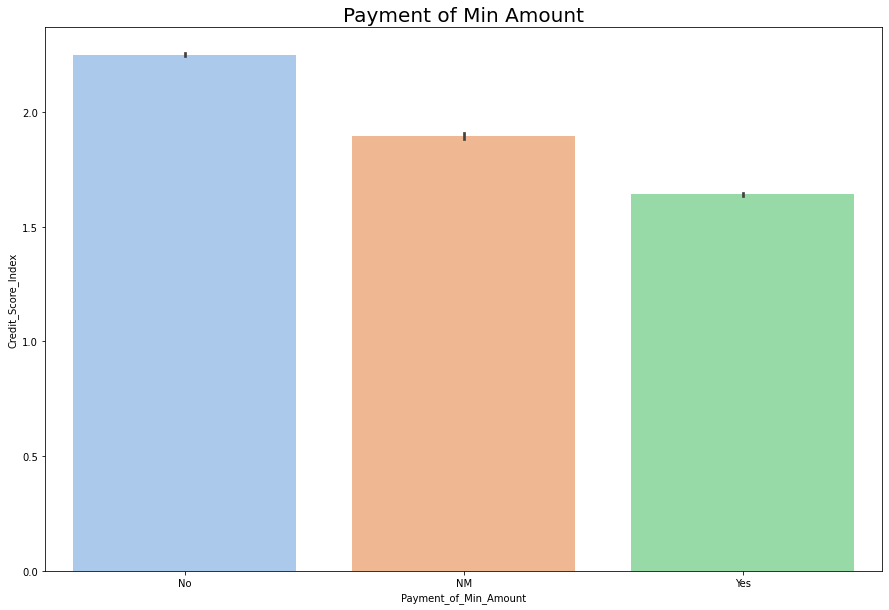

In [48]:
plt.figure(figsize=(15,10))
sns.barplot(x="Payment_of_Min_Amount", y="Credit_Score_Index", data=trainpd_df)
plt.title("Payment of Min Amount", fontsize=20)
plt.show()

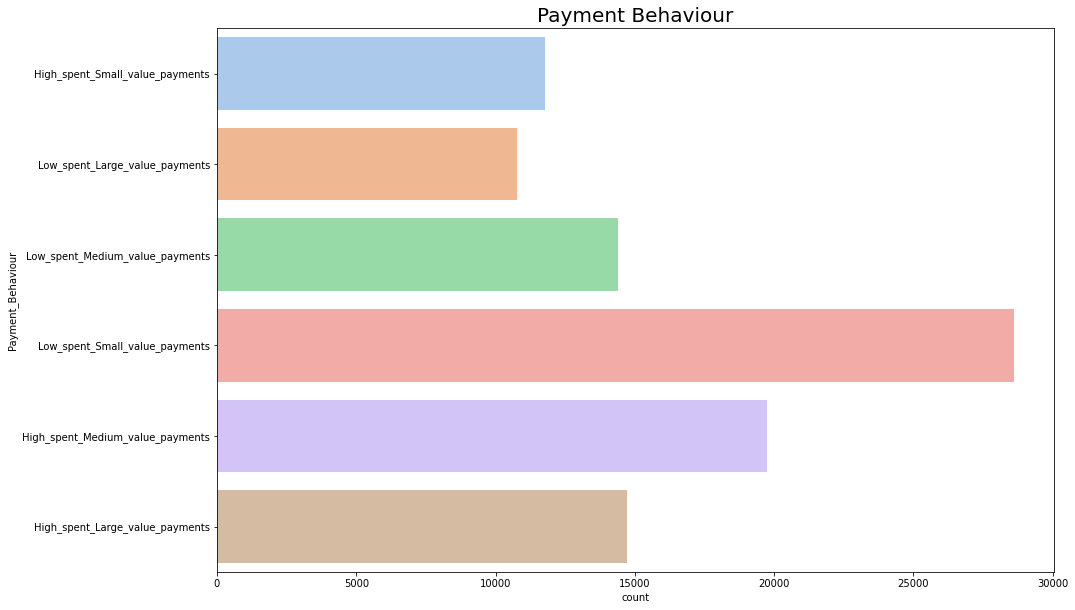

In [49]:
plt.figure(figsize=(15,10))
sns.countplot(y="Payment_Behaviour", data=trainpd_df)
plt.title("Payment Behaviour", fontsize=20)
plt.show()

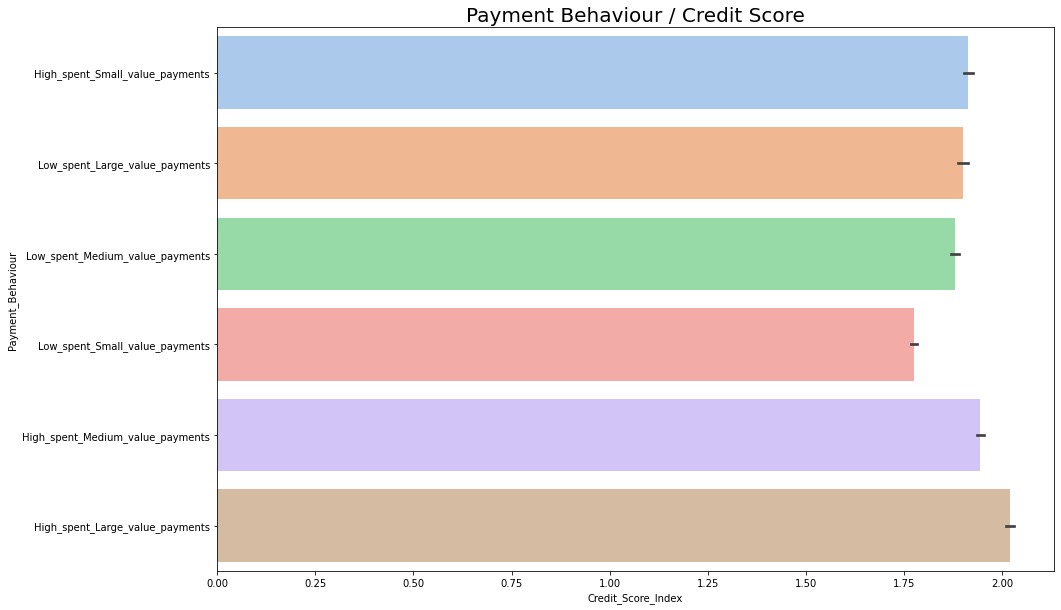

In [50]:
plt.figure(figsize=(15,10))
sns.barplot(x="Credit_Score_Index", y="Payment_Behaviour", data=trainpd_df)
plt.title("Payment Behaviour / Credit Score", fontsize=20)
plt.show()

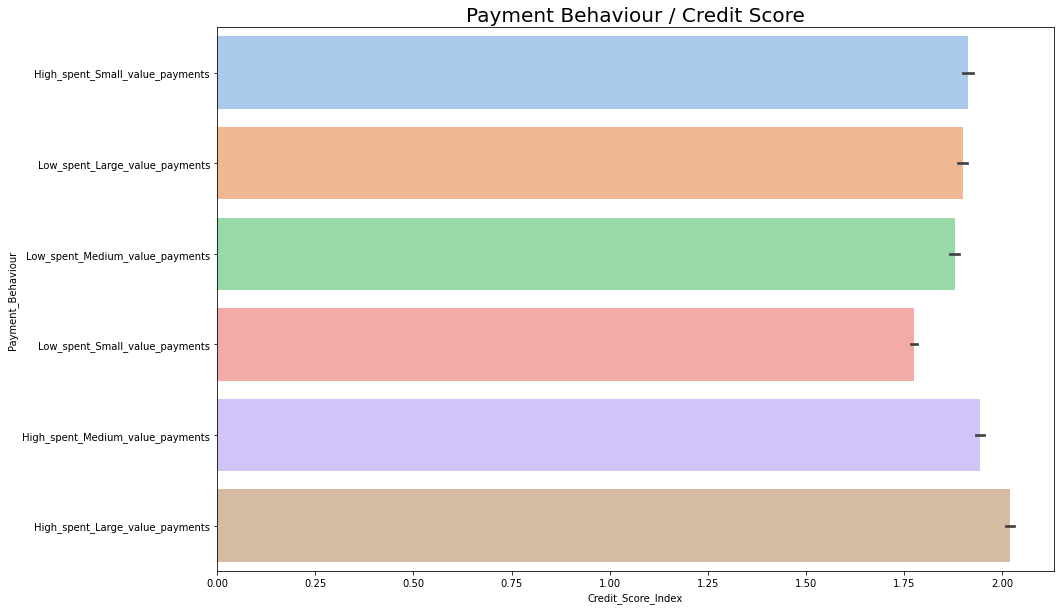

In [51]:
plt.figure(figsize=(15,10))
sns.barplot(x="Credit_Score_Index", y="Payment_Behaviour", data=trainpd_df)
plt.title("Payment Behaviour / Credit Score", fontsize=20)
plt.show()

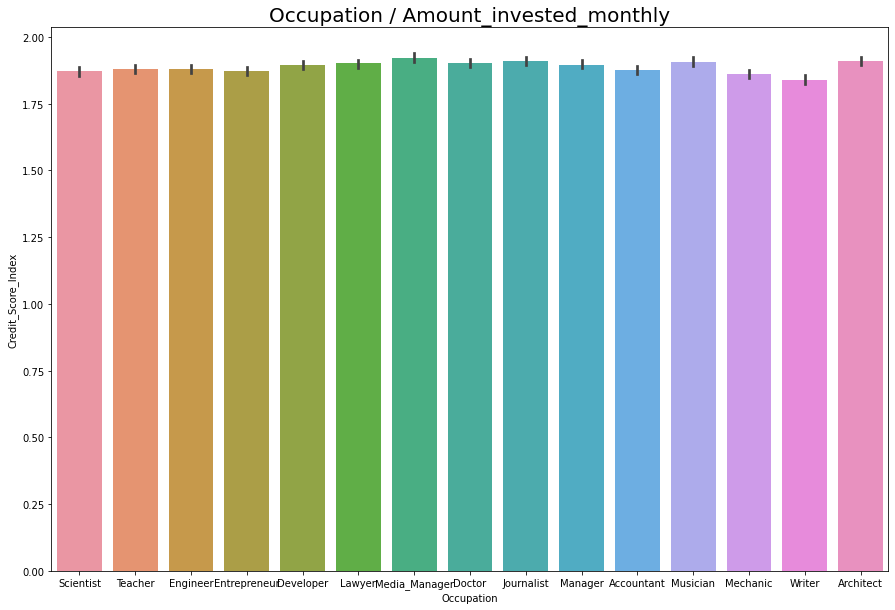

In [52]:
plt.figure(figsize=(15,10))
sns.barplot(y="Credit_Score_Index", x="Occupation", data=trainpd_df)
plt.title("Occupation / Amount_invested_monthly", fontsize=20)
plt.show()

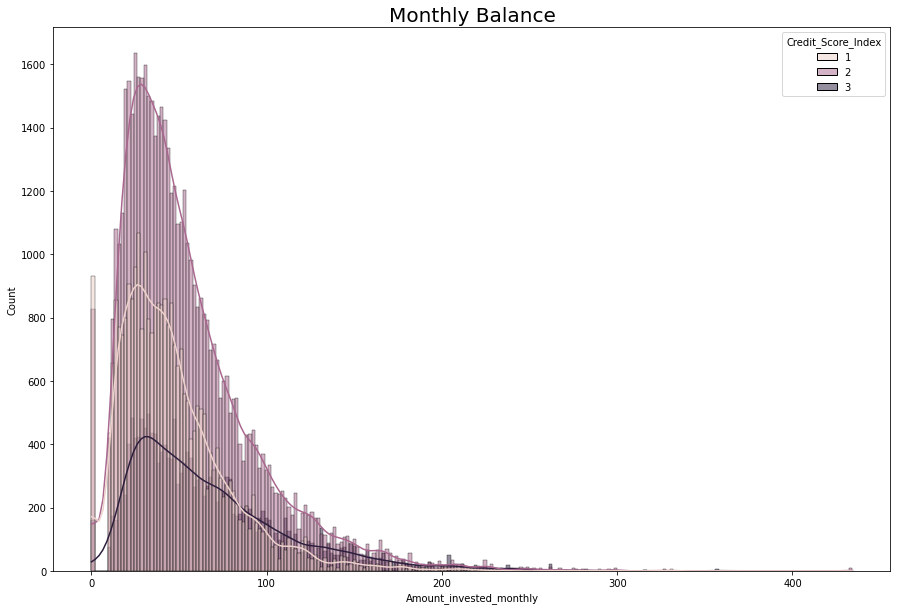

In [53]:
plt.figure(figsize=(15,10))
sns.histplot(data=trainpd_df, x="Amount_invested_monthly", kde = True, hue="Credit_Score_Index")
plt.title("Monthly Balance", fontsize=20)
plt.show()

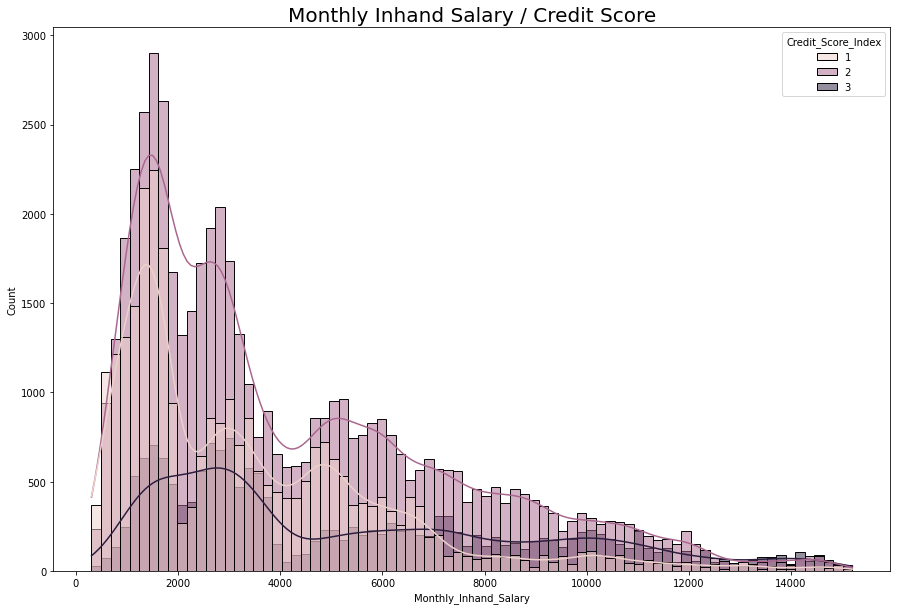

In [54]:
plt.figure(figsize=(15,10))
sns.histplot(x="Monthly_Inhand_Salary", hue="Credit_Score_Index", kde= True, data=trainpd_df)
plt.title("Monthly Inhand Salary / Credit Score", fontsize=20)
plt.show()

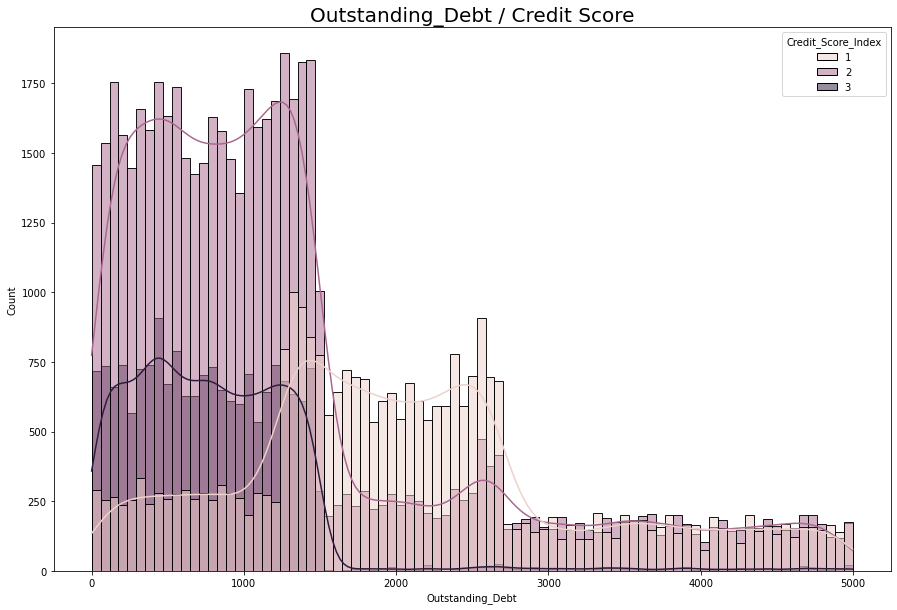

In [55]:
plt.figure(figsize=(15,10))
sns.histplot(x="Outstanding_Debt", hue="Credit_Score_Index", kde= True, data=trainpd_df)
plt.title("Outstanding_Debt / Credit Score", fontsize=20)
plt.show()

####CORRELATIONS

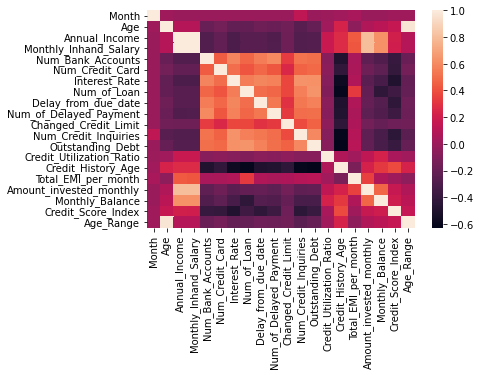

In [56]:
sns.heatmap(trainpd_df.corr())

In [57]:


from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

#df1 = df.withColumn('Credit_Score', when(df.Credit_Score == 'Poor', 0).\
#   withColumn('Credit_Score', when(df.Credit_Score == 'Standard'), 1).otherwise(2)

cols = ('Credit_Score', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour')

corr_df = newdf2.drop(*cols)

vector_col = "corr_features"
assembler = VectorAssembler(inputCols=corr_df.columns, outputCol=vector_col)
df_vector = assembler.transform(corr_df)

matrix = Correlation.corr(df_vector, vector_col)
#matrix.collect()[0]["pearson({})".format(vector_col)].values

cor_np = matrix.collect()[0][matrix.columns[0]].toArray().tolist()

corr_df = spark.createDataFrame(cor_np, ['Month', 'Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Outstanding_Debt','Credit_Utilization_Ratio', 'Credit_History_Age','Total_EMI_per_month', 'Amount_invested_monthly','Monthly_Balance', 'Credit_Score_Index'])
corr_df.show()

+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+------------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+
|               Month|                 Age|       Annual_Income|Monthly_Inhand_Salary|   Num_Bank_Accounts|     Num_Credit_Card|       Interest_Rate|         Num_of_Loan| Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|    Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age| Total_EMI_per_month|Amount_invested_monthly|     Monthly_Balance|  Credit_Score_Index|
+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------

In [58]:
corr_credit_df = corr_df.select(['Credit_Score_Index','Month', 'Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Outstanding_Debt','Credit_Utilization_Ratio', 'Credit_History_Age','Total_EMI_per_month', 'Amount_invested_monthly','Monthly_Balance'])
corr_credit_df.sort(corr_df.Credit_Score_Index.desc()).show()

+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+------------------------+--------------------+--------------------+-----------------------+--------------------+
|  Credit_Score_Index|               Month|                 Age|       Annual_Income|Monthly_Inhand_Salary|   Num_Bank_Accounts|     Num_Credit_Card|       Interest_Rate|         Num_of_Loan| Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|    Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age| Total_EMI_per_month|Amount_invested_monthly|     Monthly_Balance|
+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------

In [59]:
corr_amt_df = corr_df.select(['Amount_invested_monthly','Month', 'Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
                'Outstanding_Debt','Credit_Utilization_Ratio', 'Credit_History_Age','Total_EMI_per_month', 'Amount_invested_monthly','Monthly_Balance','Credit_Score_Index'])
corr_amt_df.sort(corr_df.Amount_invested_monthly.desc()).show()

+-----------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+------------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+
|Amount_invested_monthly|               Month|                 Age|       Annual_Income|Monthly_Inhand_Salary|   Num_Bank_Accounts|     Num_Credit_Card|       Interest_Rate|         Num_of_Loan| Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|    Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age| Total_EMI_per_month|Amount_invested_monthly|     Monthly_Balance|  Credit_Score_Index|
+-----------------------+--------------------+--------------------+--------------------+---------------------+--------------------

In [60]:
sns.pairplot(trainpd_df)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

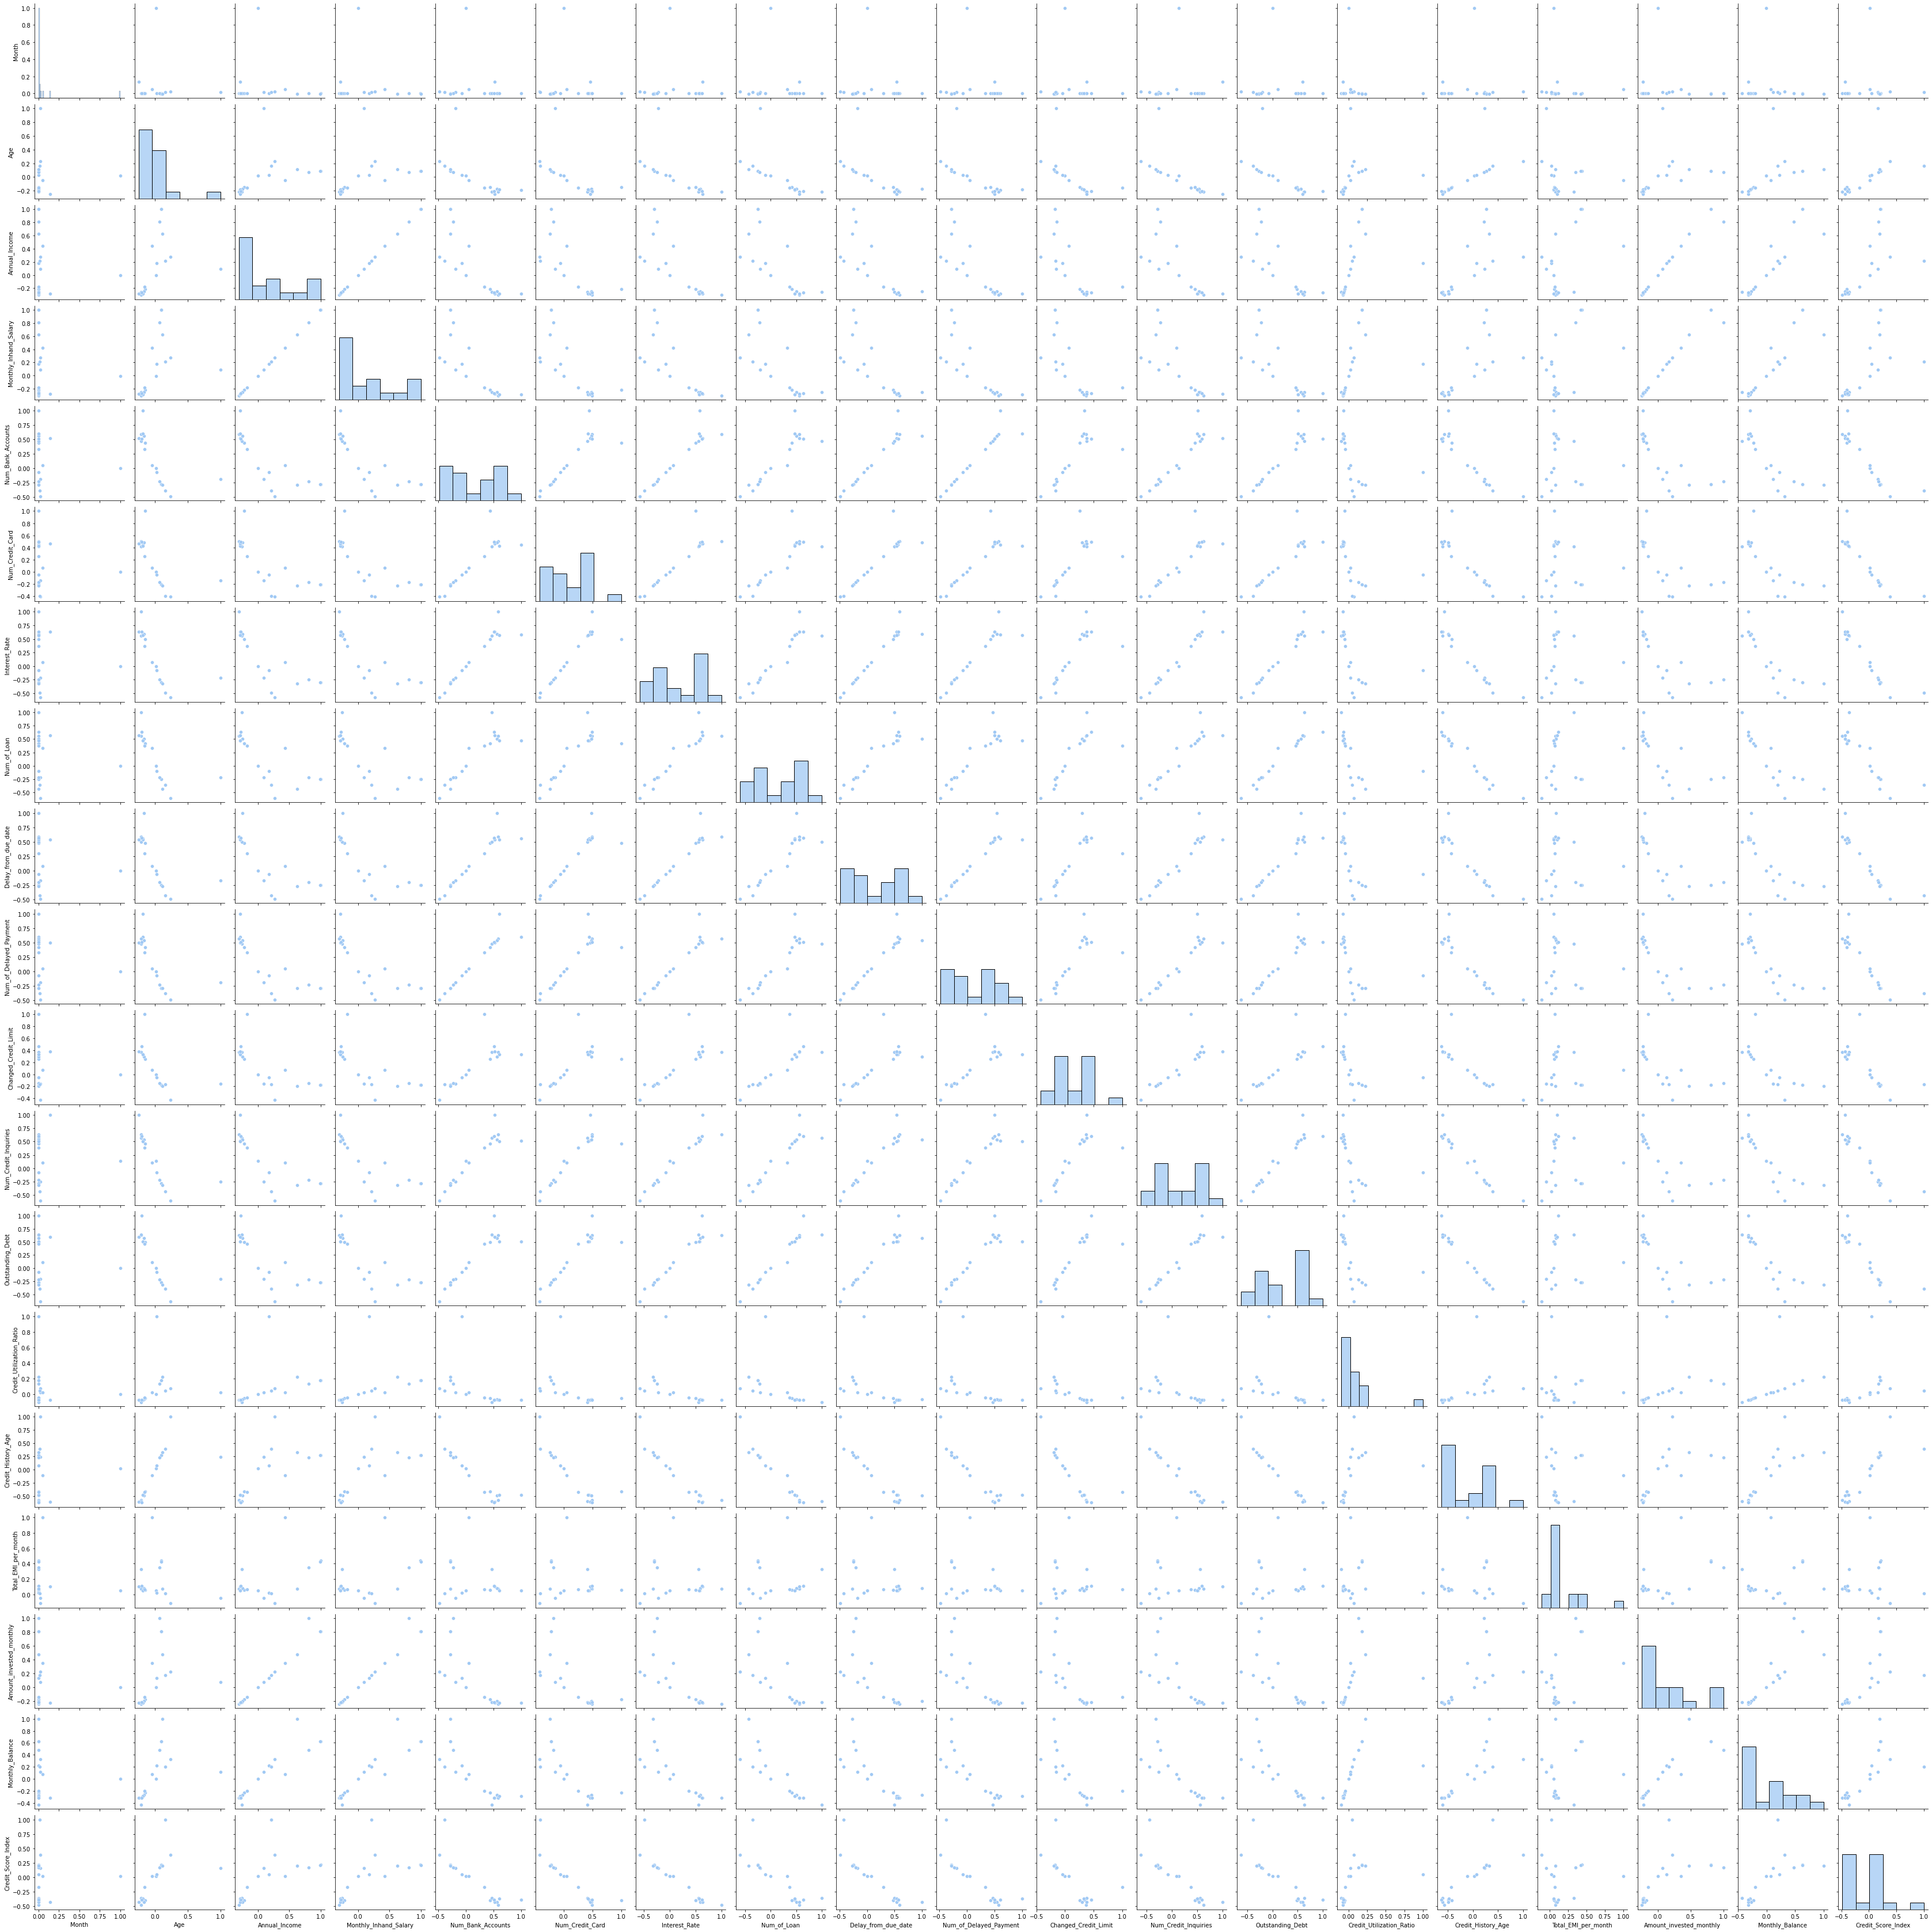

In [61]:
corr_matrix = corr_df.toPandas()
# sns.heatmap(corr_matrix, annot=True)
# plt.show()
sns.pairplot(corr_matrix)
plt.show()

#MACHINE LEARNING

##Indexing and One-Hot Encoding

In [62]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

cols = ['Occupation', 'Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']

indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in cols
]

encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

inputCols=[encoder.getOutputCol() for encoder in encoders],



pipeline = Pipeline(stages=indexers + encoders)
pipeline.fit(df).transform(df).show()

df_transformed = pipeline.fit(df).transform(df)

+-----+------------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------------+--------------------+------------------+-----------------------------+-------------------------+--------------------+--------------------------+----------------------------+--------------------------+-------------------------------------+---------------------------------+----------------------------+
|Month|Credit_Score| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_De

In [63]:
cols = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']

indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in cols
]

encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

inputCols=[encoder.getOutputCol() for encoder in encoders],



pipeline = Pipeline(stages=indexers + encoders)

above_median_income_df = pipeline.fit(above_median_income_df).transform(above_median_income_df)
below_median_income_df = pipeline.fit(below_median_income_df).transform(below_median_income_df)
above_median_age_df = pipeline.fit(above_median_age_df).transform(above_median_age_df)
below_median_age_df = pipeline.fit(below_median_age_df).transform(below_median_age_df)

##CREDIT SCORE PREDICTION

###LOG REGRESSION

####NOT TUNED

In [64]:
#from pyspark.mllib.evaluation import MulticlassClassificationMetrics


vector_assembler_lr = feature.VectorAssembler(inputCols=['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Amount_invested_monthly', 'Monthly_Balance','Occupation_indexed_encoded',
                                                       'Type_of_Loan_indexed_encoded','Credit_Mix_indexed_encoded',
                                                       'Payment_of_Min_Amount_indexed_encoded','Payment_Behaviour_indexed_encoded'],
                             outputCol = 'features')
#stdscaler = feature.StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")
#scale_pipe = Pipeline(stages=[vector_assembler_lr, stdscaler])
#df_t = scale_pipe.fit(df_transformed).transform(df_transformed)
training_df_lr, validation_df_lr, testing_df_lr = df_transformed.randomSplit([0.6, 0.3, 0.1], seed=0)

In [65]:
#df_t.printSchema()

In [66]:
lr = LogisticRegression().setLabelCol('Credit_Score_indexed').setFeaturesCol('features')
log_reg_pipe = Pipeline(stages=[vector_assembler_lr, lr])
lr_pipe = log_reg_pipe.fit(training_df_lr)
test_mod = lr_pipe.transform(testing_df_lr)

In [67]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="f1")

In [68]:
accuracy = eval_accuracy.evaluate(test_mod)
precision = eval_precision.evaluate(test_mod)
recall = eval_recall.evaluate(test_mod)
f1score = eval_f1.evaluate(test_mod)

In [69]:
print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)
print("F1", f1score)

Accuracy 0.7536058887894161
Precision 0.7790157845868152
Recall 0.7912108638249717
F1 0.7539779584066466


In [70]:
test_mod.show(5)

+-----+------------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+-----------------+------------------+--------------------+------------------+-----------------------------+-------------------------+--------------------+--------------------------+----------------------------+--------------------------+-------------------------------------+---------------------------------+----------------------------+--------------------+--------------------+--------------------+----------+
|Month|Credit_Score| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Pa

In [71]:
lr_evaluator=RegressionEvaluator(labelCol='Credit_Score_indexed',predictionCol='prediction')
inbuilt_mse=lr_evaluator.evaluate(test_mod,{lr_evaluator.metricName:'mse'})
print('MSE via inbuilt evaluator object: %f'% inbuilt_mse)

MSE via inbuilt evaluator object: 0.571073


In [72]:
inf_pd = pd.DataFrame({'predictor':log_reg_pipe.getStages()[0].getInputCols(),'value':lr_pipe.stages[1].coefficientMatrix})
display(inf_pd)

,predictor,value
0,Age,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
1,Annual_Income,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
2,Monthly_Inhand_Salary,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
3,Num_Bank_Accounts,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
4,Num_Credit_Card,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
5,Interest_Rate,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
6,Num_of_Loan,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
7,Delay_from_due_date,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
8,Num_of_Delayed_Payment,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
9,Changed_Credit_Limit,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


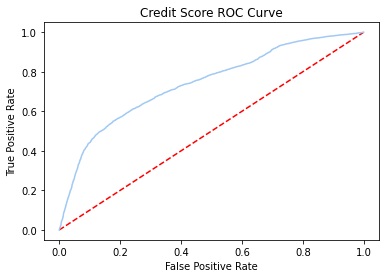

In [73]:
predictions = log_reg_pipe.fit(training_df_lr).transform(testing_df_lr)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('Credit_Score_indexed','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['Credit_Score_indexed'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
plt.plot([0,1],[0,1],"r--")
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Credit Score ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

In [74]:
confusion_matrix = (test_mod.groupby('Credit_Score_indexed').pivot('prediction').count().toPandas()
                    .set_index('Credit_Score_indexed').sort_index(axis='index', ascending=False).sort_index(axis='columns', ascending=False)
                    .fillna(0).astype(int)
                    )
print(confusion_matrix)

                       2.0   1.0   0.0
Credit_Score_indexed                  
2.0                   1258    40   537
1.0                    140  2123   653
0.0                    551   556  4195


####HP Tuning

In [75]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0]) \
    .addGrid(lr.regParam, [0.1]) \
    .build()

strat_pipe = Pipeline(stages=[vector_assembler_lr, lr])
evaluator = MulticlassClassificationEvaluator(labelCol=lr.getLabelCol(), predictionCol=lr.getPredictionCol())
crossval = CrossValidator(estimator=strat_pipe, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=3)
evaluation_model = strat_pipe.fit(training_df_lr)

In [76]:
final_model_fitted = crossval.fit(training_df_lr)
final_model_test = final_model_fitted.transform(testing_df_lr)

In [77]:
accuracy = eval_accuracy.evaluate(final_model_test)
precision = eval_precision.evaluate(final_model_test)
recall = eval_recall.evaluate(final_model_test)
f1score = eval_f1.evaluate(final_model_test)

In [78]:
print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)
print("F1", f1score)

Accuracy 0.7449517556948174
Precision 0.7582670203359858
Recall 0.8087514145605432
F1 0.744404682554284


In [79]:
inf_pd_tuned = pd.DataFrame({'predictor':log_reg_pipe.getStages()[0].getInputCols(),'value':lr_pipe.stages[1].coefficientMatrix})
display(inf_pd)

,predictor,value
0,Age,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
1,Annual_Income,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
2,Monthly_Inhand_Salary,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
3,Num_Bank_Accounts,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
4,Num_Credit_Card,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
5,Interest_Rate,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
6,Num_of_Loan,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
7,Delay_from_due_date,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
8,Num_of_Delayed_Payment,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."
9,Changed_Credit_Limit,"DenseMatrix([[-1.03551126e-03, 5.28994753e-07..."


In [80]:
confusion_matrix = (final_model_test.groupby('Credit_Score_indexed').pivot('prediction').count().toPandas()
                    .set_index('Credit_Score_indexed').sort_index(axis='index', ascending=False).sort_index(axis='columns', ascending=False)
                    .fillna(0).astype(int)
                    )
print(confusion_matrix)

                       2.0   1.0   0.0
Credit_Score_indexed                  
2.0                   1206    20   609
1.0                    163  1995   758
0.0                    526   488  4288


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


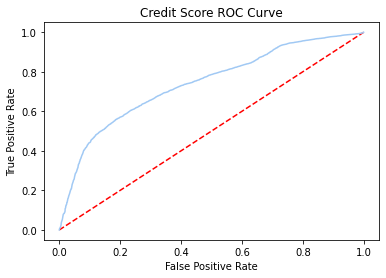

In [81]:
predictions = strat_pipe.fit(training_df_lr).transform(testing_df_lr)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('Credit_Score_indexed','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['Credit_Score_indexed'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
plt.plot([0,1],[0,1],"r--")
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Credit Score ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

###Random Forest

####NOT TUNED

In [82]:
training_df_dt, validation_df_dt, testing_df_dt = df_transformed.randomSplit([0.6, 0.3, 0.1], seed=0)
vector_assembler_dt = feature.VectorAssembler(inputCols=['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Amount_invested_monthly', 'Monthly_Balance','Occupation_indexed',
                                                       'Credit_Mix_indexed',
                                                       'Payment_of_Min_Amount_indexed','Payment_Behaviour_indexed'],
                             outputCol = 'features')
training_df_dt = training_df_dt.withColumnRenamed('Credit_Score_indexed', 'label')
training_df_dt = training_df_dt.withColumn('label', training_df_dt['label'].cast(IntegerType()))

validation_df_dt = validation_df_dt.withColumnRenamed('Credit_Score_indexed', 'label')


testing_df_dt = testing_df_dt.withColumnRenamed('Credit_Score_indexed', 'label')

In [83]:
rf = RandomForestClassifier(labelCol = 'label', featuresCol = 'features')
rf_pipeline = Pipeline(stages=[vector_assembler_dt, rf]).fit(training_df_dt)
test_mod_dt = rf_pipeline.transform(validation_df_dt)
rf_evaluator=RegressionEvaluator(labelCol='label',predictionCol='prediction')
inbuilt_mse=rf_evaluator.evaluate(test_mod_dt,{rf_evaluator.metricName:'mse'})
print('MSE via inbuilt evaluator object: %f'% inbuilt_mse)

MSE via inbuilt evaluator object: 0.700489


In [84]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [85]:
accuracy = eval_accuracy.evaluate(test_mod_dt)
precision = eval_precision.evaluate(test_mod_dt)
recall = eval_recall.evaluate(test_mod_dt)
f1score = eval_f1.evaluate(test_mod_dt)

In [86]:
print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)
print("F1", f1score)

Accuracy 0.6899471253597483
Precision 0.7734667434494673
Recall 0.6749795841447327
F1 0.6933718451455061


In [87]:
rf_feature_importance = pd.DataFrame(list(zip(training_df_dt.columns[1:], rf_pipeline.stages[1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

In [88]:
display(rf_feature_importance)

,feature,importance
18,Payment_of_Min_Amount,0.309607
11,Num_of_Delayed_Payment,0.202487
5,Num_Bank_Accounts,0.139525
7,Interest_Rate,0.089960
19,Total_EMI_per_month,0.052974
13,Num_Credit_Inquiries,0.052069
10,Delay_from_due_date,0.045966
4,Monthly_Inhand_Salary,0.033662
9,Type_of_Loan,0.031578
8,Num_of_Loan,0.015589


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


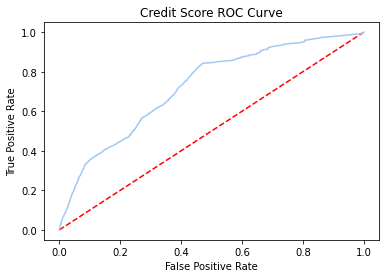

In [89]:
predictions = rf_pipeline.transform(testing_df_dt)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
plt.plot([0,1],[0,1],"r--")
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Credit Score ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

####HP Tuning


In [90]:
if enable_grid:
  cv_pipe = Pipeline(stages=[vector_assembler_dt, rf])
  grid = ParamGridBuilder().addGrid(rf.maxDepth, [20, 30]) \
            .addGrid(rf.numTrees, [20, 30]) \
            .addGrid(rf.maxBins, [30, 35]) \
            .build()

  crossvalidation = CrossValidator(estimator= cv_pipe,
                          estimatorParamMaps= grid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3) 

  cv_model = crossvalidation.fit(training_df_dt)
  predictions = cv_model.transform(testing_df_dt)
  evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
  accuracy = evaluator.evaluate(predictions)

  bestPipeline = cv_model.bestModel
  bestModel = bestPipeline.stages[1]
  print('numTrees: ', bestModel.getNumTrees)
  print('maxDepth: ', bestModel.getOrDefault('maxDepth'))
  print('maxBins: ', bestModel.getOrDefault('maxBins'))
  print(accuracy)
pass

In [91]:
rf_best = RandomForestClassifier(labelCol = 'label', featuresCol = 'features')\
     .setMaxDepth(30).setNumTrees(30).setMaxBins(30)
best_rf_pipe = Pipeline(stages = [vector_assembler_dt, rf_best])
rf_best_model = best_rf_pipe.fit(training_df_dt)

In [92]:
predictions = rf_best_model.transform(validation_df_dt)

In [93]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [94]:
accuracy = eval_accuracy.evaluate(predictions)
precision = eval_precision.evaluate(predictions)

In [95]:
print("Accuracy", accuracy)
print("Precision", precision)

Accuracy 0.7997456662873971
Precision 0.8211262185736276


In [96]:
rf_feature_importance = pd.DataFrame(list(zip(training_df_dt.columns[1:], rf_best_model.stages[1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

In [97]:
display(rf_feature_importance)

,feature,importance
11,Num_of_Delayed_Payment,0.098159
18,Payment_of_Min_Amount,0.085316
5,Num_Bank_Accounts,0.085047
7,Interest_Rate,0.063416
9,Type_of_Loan,0.053532
0,Credit_Score,0.052933
12,Changed_Credit_Limit,0.052311
17,Credit_History_Age,0.050291
13,Num_Credit_Inquiries,0.048114
10,Delay_from_due_date,0.047584


####Above Median Age Feature Importance

In [98]:
above_median_age_df = above_median_age_df.drop(*cols)
above_median_age_df = above_median_age_df.drop("Type_of_Loan")

In [99]:
high_train, high_test, high_validation = above_median_age_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [100]:
vector_assembler_dt = feature.VectorAssembler(inputCols=['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Amount_invested_monthly', 'Monthly_Balance','Occupation_indexed',
                                                       'Credit_Mix_indexed',
                                                       'Payment_of_Min_Amount_indexed','Payment_Behaviour_indexed'],
                             outputCol = 'features')

In [101]:
rf_best = RandomForestClassifier(labelCol = 'Credit_Score_indexed', featuresCol = 'features')\
     .setMaxDepth(30).setNumTrees(30).setMaxBins(30)
best_rf_pipe = Pipeline(stages = [vector_assembler_dt, rf_best])
rf_best_model = best_rf_pipe.fit(high_train)

In [102]:
predictions = rf_best_model.transform(high_validation)

In [103]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="f1")

accuracy = eval_accuracy.evaluate(predictions)
precision = eval_precision.evaluate(predictions)


print("Accuracy", accuracy)
print("Precision", precision)

Accuracy 0.8009396206716548
Precision 0.8233952427500815


In [104]:
rf_feature_importance = pd.DataFrame(list(zip(high_train.columns[1:], rf_best_model.stages[1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

display(rf_feature_importance)

,feature,importance
18,Credit_Mix_indexed,0.097910
11,Outstanding_Debt,0.084947
5,Interest_Rate,0.083860
7,Delay_from_due_date,0.063558
13,Credit_History_Age,0.053087
12,Credit_Utilization_Ratio,0.052466
0,Age,0.051514
9,Changed_Credit_Limit,0.051507
17,Occupation_indexed,0.049977
16,Monthly_Balance,0.046967


####Below Median Age Feature Importance

In [105]:
below_median_age_df = below_median_age_df.drop(*cols)
below_median_age_df = below_median_age_df.drop("Type_of_Loan")

In [106]:
low_train, low_test, low_validation = below_median_age_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [107]:
vector_assembler_dt = feature.VectorAssembler(inputCols=['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Amount_invested_monthly', 'Monthly_Balance','Occupation_indexed',
                                                       'Credit_Mix_indexed',
                                                       'Payment_of_Min_Amount_indexed','Payment_Behaviour_indexed'],
                             outputCol = 'features')

In [108]:
rf_best = RandomForestClassifier(labelCol = 'Credit_Score_indexed', featuresCol = 'features')\
     .setMaxDepth(30).setNumTrees(30).setMaxBins(30)
best_rf_pipe = Pipeline(stages = [vector_assembler_dt, rf_best])
rf_best_model = best_rf_pipe.fit(low_train)

In [109]:
predictions = rf_best_model.transform(low_validation)

In [110]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="f1")

In [111]:
accuracy = eval_accuracy.evaluate(predictions)
precision = eval_precision.evaluate(predictions)

In [112]:
print("Accuracy", accuracy)
print("Precision", precision)

Accuracy 0.793465577596266
Precision 0.8124137931034483


In [113]:
rf_feature_importance = pd.DataFrame(list(zip(low_train.columns[1:], rf_best_model.stages[1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

In [114]:
display(rf_feature_importance)

,feature,importance
11,Credit_Utilization_Ratio,0.120404
5,Num_of_Loan,0.075440
18,Payment_of_Min_Amount_indexed,0.070295
7,Num_of_Delayed_Payment,0.070129
9,Num_Credit_Inquiries,0.055145
12,Credit_History_Age,0.051839
13,Total_EMI_per_month,0.051328
17,Credit_Mix_indexed,0.050996
10,Outstanding_Debt,0.049740
0,Annual_Income,0.046813


####HIGH INCOME FEATURE IMPORTANCE

In [115]:
above_median_income_df = below_median_income_df.drop(*cols)
above_median_income_df = below_median_income_df.drop("Type_of_Loan").drop("Type_of_Loan_indexed")

In [116]:
high_inc_train, high_inc_test, high_inc_validation = above_median_income_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [117]:
vector_assembler_dt = feature.VectorAssembler(inputCols=['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Amount_invested_monthly', 'Monthly_Balance','Occupation_indexed',
                                                       'Credit_Mix_indexed',
                                                       'Payment_of_Min_Amount_indexed','Payment_Behaviour_indexed'],
                             outputCol = 'features')

In [118]:
rf_best = RandomForestClassifier(labelCol = 'Credit_Score_indexed', featuresCol = 'features')\
     .setMaxDepth(30).setNumTrees(30).setMaxBins(30)
best_rf_pipe = Pipeline(stages = [vector_assembler_dt, rf_best])
rf_best_model = best_rf_pipe.fit(high_inc_train)

In [119]:
predictions = rf_best_model.transform(high_inc_validation)

In [120]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="f1")

accuracy = eval_accuracy.evaluate(predictions)
precision = eval_precision.evaluate(predictions)

print("Accuracy", accuracy)
print("Precision", precision)

Accuracy 0.8088635800940827
Precision 0.8274378585086042


In [121]:
rf_feature_importance = pd.DataFrame(list(zip(high_inc_train.columns[1:], rf_best_model.stages[1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

display(rf_feature_importance)

,feature,importance
11,Changed_Credit_Limit,0.116180
5,Num_Bank_Accounts,0.080981
18,Total_EMI_per_month,0.071931
7,Interest_Rate,0.059675
10,Num_of_Delayed_Payment,0.057163
9,Delay_from_due_date,0.056432
13,Credit_Mix,0.054768
12,Num_Credit_Inquiries,0.052996
17,Payment_of_Min_Amount,0.050097
16,Credit_History_Age,0.049705


####LOW INCOME FEATURE IMPORTANCE

In [122]:
below_median_income_df = below_median_income_df.drop(*cols)
below_median_income_df = below_median_income_df.drop("Type_of_Loan")

In [123]:
low_inc_train, low_inc_test, low_inc_validation = below_median_income_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [124]:
vector_assembler_dt = feature.VectorAssembler(inputCols=['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Amount_invested_monthly', 'Monthly_Balance','Occupation_indexed',
                                                       'Credit_Mix_indexed',
                                                       'Payment_of_Min_Amount_indexed','Payment_Behaviour_indexed'],
                             outputCol = 'features')

In [125]:
rf_best = RandomForestClassifier(labelCol = 'Credit_Score_indexed', featuresCol = 'features')\
     .setMaxDepth(30).setNumTrees(30).setMaxBins(30)
best_rf_pipe = Pipeline(stages = [vector_assembler_dt, rf_best])
rf_best_model = best_rf_pipe.fit(low_inc_train)

In [126]:
predictions = rf_best_model.transform(low_inc_validation)

In [127]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol="Credit_Score_indexed", predictionCol="prediction", metricName="f1")

accuracy = eval_accuracy.evaluate(predictions)
precision = eval_precision.evaluate(predictions)

print("Accuracy", accuracy)
print("Precision", precision)

Accuracy 0.8091111661302303
Precision 0.8355834136933462


In [128]:
rf_feature_importance = pd.DataFrame(list(zip(low_inc_train.columns[1:], rf_best_model.stages[1].featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)

display(rf_feature_importance)

,feature,importance
11,Outstanding_Debt,0.113431
5,Interest_Rate,0.083695
18,Credit_Mix_indexed,0.072778
9,Changed_Credit_Limit,0.057916
13,Credit_History_Age,0.055804
7,Delay_from_due_date,0.055401
10,Num_Credit_Inquiries,0.055315
12,Credit_Utilization_Ratio,0.053156
17,Occupation_indexed,0.050499
0,Age,0.050200


###MULTILAYER PERCEPTRON

####NOT TUNED

In [129]:
from pyspark.ml import classification

In [130]:
vector_assembler_dt = feature.VectorAssembler(inputCols=['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Amount_invested_monthly', 'Monthly_Balance','Occupation_indexed',
                                                       'Credit_Mix_indexed',
                                                       'Payment_of_Min_Amount_indexed','Payment_Behaviour_indexed'],
                             outputCol = 'features')

training_df_dt, validation_df_dt, testing_df_dt = df_transformed.randomSplit([0.6, 0.3, 0.1], seed=0)
training_df_dt = training_df_dt.withColumnRenamed('Credit_Score_indexed', 'label')
training_df_dt = training_df_dt.withColumn('label', training_df_dt['label'].cast(IntegerType()))

validation_df_dt = validation_df_dt.withColumnRenamed('Credit_Score_indexed', 'label')


testing_df_dt = testing_df_dt.withColumnRenamed('Credit_Score_indexed', 'label')
mlp = classification.MultilayerPerceptronClassifier(layers = [21, 15, 3], seed=0).\
    setStepSize(0.2).\
    setMaxIter(200).\
    setFeaturesCol('features')
mlp_pipeline = Pipeline(stages=[vector_assembler_dt, mlp])
mlp_model = mlp_pipeline.fit(training_df_dt)

In [131]:
mlp_fitted = mlp_model.transform(testing_df_dt)

In [132]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [133]:
accuracy = eval_accuracy.evaluate(mlp_fitted)
precision = eval_precision.evaluate(mlp_fitted)
recall = eval_recall.evaluate(mlp_fitted)
f1score = eval_f1.evaluate(mlp_fitted)

In [134]:
print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)
print("F1", f1score)

Accuracy 0.5274047547995623
Precision 0.5274102079395085
Recall 0.9998113919275745
F1 0.36439767657830574


#### HP TUNING

In [135]:
training_df_dt, validation_df_dt, testing_df_dt = df_transformed.randomSplit([0.6, 0.3, 0.1], seed=0)
training_df_dt = training_df_dt.withColumnRenamed('Credit_Score_indexed', 'label')
training_df_dt = training_df_dt.withColumn('label', training_df_dt['label'].cast(IntegerType()))

validation_df_dt = validation_df_dt.withColumnRenamed('Credit_Score_indexed', 'label')


testing_df_dt = testing_df_dt.withColumnRenamed('Credit_Score_indexed', 'label')

In [136]:
if enable_grid:
  vector_assembler_dt = feature.VectorAssembler(inputCols=['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Amount_invested_monthly', 'Monthly_Balance','Occupation_indexed',
                                                       'Credit_Mix_indexed',
                                                       'Payment_of_Min_Amount_indexed','Payment_Behaviour_indexed'],
                             outputCol = 'features')

  evaluator = evaluation.MulticlassClassificationEvaluator(metricName="accuracy")

  mlp = classification.MultilayerPerceptronClassifier(labelCol='label', featuresCol='features', seed=300)
  mlp_pipe = Pipeline(stages=[vector_assembler_dt, mlp])

  l1 = [21,33,3]
  l2 = [21,45,3]
  l3 = [21,60,3]

  grid = ParamGridBuilder().addGrid(mlp.maxIter, [250, 275, 300]) \
          .addGrid(mlp.stepSize, [0.2, 0.3]) \
          .addGrid(mlp.solver, ['l-bfgs', 'gd'])\
          .addGrid(mlp.layers,[l1,l2,l3]).build()

  crossvalidation = CrossValidator(estimator= mlp_pipe,
                        estimatorParamMaps= grid,
                        evaluator= evaluator,
                        numFolds=3) 



  cv_model = crossvalidation.fit(training_df_dt)
  predictions = cv_model.transform(testing_df_dt)

  bestPipeline = cv_model.bestModel
  bestModel = bestPipeline.stages[1]
  print('maxIter: ', bestModel.getOrDefault('maxIter'))
  print('stepSize: ', bestModel.getOrDefault('stepSize'))
  print('solver: ', bestModel.getOrDefault('solver'))
  print('layers: ', bestModel.getOrDefault('layers'))
pass

In [137]:
best_mlp = classification.MultilayerPerceptronClassifier(seed = 300).\
            setStepSize(0.2).\
            setMaxIter(250).\
            setFeaturesCol('features').\
            setLayers([21, 45, 3]).\
            setSolver('l-bfgs')

best_mlp_pipeline = Pipeline(stages=[vector_assembler_dt, best_mlp])
best_mlp_model = best_mlp_pipeline.fit(training_df_dt)

In [138]:
best_mlp_fitted = best_mlp_model.transform(validation_df_dt)

In [139]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
eval_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
eval_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
eval_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

In [140]:
accuracy = eval_accuracy.evaluate(best_mlp_fitted)
precision = eval_precision.evaluate(best_mlp_fitted)
recall = eval_recall.evaluate(best_mlp_fitted)
f1score = eval_f1.evaluate(best_mlp_fitted)

In [141]:
print("Accuracy", accuracy)
print("Precision", precision)
print("Recall", recall)
print("F1", f1score)

Accuracy 0.6056488856167592
Precision 0.6167342150170648
Recall 0.7264903574345122
F1 0.547555433243474


##Predicting Monthly Investment

###Linear Regression

####NOT TUNED

In [142]:
vector_assembler_lr = feature.VectorAssembler(inputCols=['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Credit_Score_indexed', 'Monthly_Balance','Occupation_indexed_encoded',
                                                       'Type_of_Loan_indexed_encoded','Credit_Mix_indexed_encoded',
                                                       'Payment_of_Min_Amount_indexed_encoded','Payment_Behaviour_indexed_encoded'],
                             outputCol = 'features')
training_df_lr, validation_df_lr, testing_df_lr = df_transformed.randomSplit([0.6, 0.3, 0.1], seed=0)
linear_reg = regression.LinearRegression(labelCol='label', featuresCol="features")

In [143]:
training_df_lr = training_df_lr.withColumnRenamed("Amount_invested_monthly", "label")
stdscaler = feature.StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")
lr_pipe = Pipeline(stages = [vector_assembler_lr, linear_reg])
lr_model = lr_pipe.fit(training_df_lr)
lr_df = lr_model.transform(testing_df_lr)

In [144]:
lr_evaluator=RegressionEvaluator(labelCol='Amount_invested_monthly',predictionCol='prediction')
mse=lr_evaluator.evaluate(lr_df,{lr_evaluator.metricName:'mse'})
rmse=lr_evaluator.evaluate(lr_df,{lr_evaluator.metricName:'rmse'})
r2=lr_evaluator.evaluate(lr_df,{lr_evaluator.metricName:'r2'})
mae=lr_evaluator.evaluate(lr_df,{lr_evaluator.metricName:'mae'})
var=lr_evaluator.evaluate(lr_df,{lr_evaluator.metricName:'var'})
print('MSE: %f'% mse)
print('RMSE: %f'% rmse)
print('R2: %f'% r2)
print('MAE: %f'% mae)
print('VAR: %f'% var)

MSE: 314.518232
RMSE: 17.734662
R2: 0.787492
MAE: 10.118296
VAR: 1180.259857


####HP Tuning

In [145]:
training_df_lr = training_df_lr.withColumnRenamed('Amount_invested_monthly', 'label')
validation_df_lr = validation_df_lr.withColumnRenamed('Amount_invested_monthly', 'label')


testing_df_lr = testing_df_lr.withColumnRenamed('Amount_invested_monthly', 'label')


In [146]:
vector_assembler_lr = feature.VectorAssembler(inputCols=['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Credit_Score_indexed', 'Monthly_Balance','Occupation_indexed_encoded',
                                                       'Type_of_Loan_indexed_encoded','Credit_Mix_indexed_encoded',
                                                       'Payment_of_Min_Amount_indexed_encoded','Payment_Behaviour_indexed_encoded'],
                                              outputCol = 'features')
                                              
linear_reg = regression.LinearRegression(labelCol='label')
linear_pipe = Pipeline(stages = [vector_assembler_lr, linear_reg])
paramGrid = ParamGridBuilder()\
    .addGrid(linear_reg.regParam, [0.1, 0.01]) \
    .addGrid(linear_reg.fitIntercept, [False, True])\
    .addGrid(linear_reg.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

cv = CrossValidator(estimator=linear_pipe,
                    estimatorParamMaps=paramGrid,
                    evaluator=RegressionEvaluator(),
                    numFolds=3)

final_model_fitted = cv.fit(training_df_lr)
final_model_test = final_model_fitted.transform(testing_df_lr)

In [147]:
lr_evaluator=RegressionEvaluator(labelCol='label',predictionCol='prediction')
mse=lr_evaluator.evaluate(final_model_test,{lr_evaluator.metricName:'mse'})
rmse=lr_evaluator.evaluate(final_model_test,{lr_evaluator.metricName:'rmse'})
r2=lr_evaluator.evaluate(final_model_test,{lr_evaluator.metricName:'r2'})
mae=lr_evaluator.evaluate(final_model_test,{lr_evaluator.metricName:'mae'})
var=lr_evaluator.evaluate(final_model_test,{lr_evaluator.metricName:'var'})
print('MSE: %f'% mse)
print('RMSE: %f'% rmse)
print('R2: %f'% r2)
print('MAE: %f'% mae)
print('VAR: %f'% var)

MSE: 314.600261
RMSE: 17.736974
R2: 0.787436
MAE: 10.116860
VAR: 1179.672002


###Random Forest

####NOT TUNED

In [148]:

training_df_dt, validation_df_dt, testing_df_dt = df_transformed.randomSplit([0.6, 0.3, 0.1], seed=0)
df_cols = ['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Credit_Score_indexed', 'Monthly_Balance','Occupation_indexed',
                                                       'Credit_Mix_indexed',
                                                       'Payment_of_Min_Amount_indexed','Payment_Behaviour_indexed']
va_rf = VectorAssembler().setInputCols(df_cols).setOutputCol('features')
rf = RandomForestRegressor(labelCol = 'label', featuresCol = 'features')
rf_pipeline = Pipeline(stages = [va_rf, rf])

In [149]:
training_df_dt = training_df_dt.withColumnRenamed('Amount_invested_monthly', 'label')
validation_df_dt = validation_df_dt.withColumnRenamed('Amount_invested_monthly', 'label')


testing_df_dt = testing_df_dt.withColumnRenamed('Amount_invested_monthly', 'label')

In [150]:
rf_mod = rf_pipeline.fit(training_df_dt)
rf_df = rf_mod.transform(testing_df_dt)

In [151]:
rf_evaluator=RegressionEvaluator(labelCol='label',predictionCol='prediction')
mse=rf_evaluator.evaluate(rf_df,{rf_evaluator.metricName:'mse'})
rmse=rf_evaluator.evaluate(rf_df,{rf_evaluator.metricName:'rmse'})
r2=rf_evaluator.evaluate(rf_df,{rf_evaluator.metricName:'r2'})
mae=rf_evaluator.evaluate(rf_df,{rf_evaluator.metricName:'mae'})
var=rf_evaluator.evaluate(rf_df,{rf_evaluator.metricName:'var'})
print('MSE: %f'% mse)
print('RMSE: %f'% rmse)
print('R2: %f'% r2)
print('MAE: %f'% mae)
print('VAR: %f'% var)

MSE: 509.968669
RMSE: 22.582486
R2: 0.655433
MAE: 15.984522
VAR: 903.914943


####HP TUNING

In [152]:
training_df_dt, validation_df_dt, testing_df_dt = df_transformed.randomSplit([0.6, 0.3, 0.1], seed=0)
df_cols = ['Age','Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
                                                       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
                                                       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                                                       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
                                                       'Credit_Score_indexed', 'Monthly_Balance','Occupation_indexed',
                                                       'Credit_Mix_indexed',
                                                       'Payment_of_Min_Amount_indexed','Payment_Behaviour_indexed']
va_rf = VectorAssembler().setInputCols(df_cols).setOutputCol('features')
rf = RandomForestRegressor(labelCol = 'label', featuresCol = 'features')
rf_pipeline = Pipeline(stages = [va_rf, rf])

In [153]:
training_df_dt = training_df_dt.withColumnRenamed('Amount_invested_monthly', 'label')
validation_df_dt = validation_df_dt.withColumnRenamed('Amount_invested_monthly', 'label')


testing_df_dt = testing_df_dt.withColumnRenamed('Amount_invested_monthly', 'label')

In [154]:
training_df_dt.show(5)

+-----+------------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+------------------+--------------------+------------------+------------------+--------------------+------------------+-----------------------------+-------------------------+--------------------+--------------------------+----------------------------+--------------------------+-------------------------------------+---------------------------------+----------------------------+
|Month|Credit_Score| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Cr

In [155]:
if enable_grid:
  rfparamGrid = ParamGridBuilder().addGrid(rf.maxDepth, [2, 5, 10])\
                .addGrid(rf.maxBins, [15, 20, 30])\
                .addGrid(rf.numTrees, [5, 20, 50]).build()

  crossvalidation = CrossValidator(estimator= rf_pipeline,
                          estimatorParamMaps= rfparamGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

  cv_model = crossvalidation.fit(training_df_dt)
  predictions = cv_model.transform(testing_df_dt)
  evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
  mse = evaluator.evaluate(predictions)
  print("Mean Squared Error (MSE): ", mse)

  bestPipeline = cv_model.bestModel
  bestModel = bestPipeline.stages[1]
  print('numTrees: ', bestModel.getNumTrees)
  print('maxDepth: ', bestModel.getOrDefault('maxDepth'))
  print('maxBins: ', bestModel.getOrDefault('maxBins'))
pass

In [156]:
rf_best = RandomForestRegressor(labelCol = 'label', featuresCol = 'features')\
     .setMaxDepth(10).setNumTrees(50).setMaxBins(30)
best_rf_pipe = Pipeline(stages = [va_rf, rf_best])
rf_best_model = best_rf_pipe.fit(training_df_dt)

In [157]:
predictions = rf_best_model.transform(validation_df_dt)

In [158]:
rf_evaluator=RegressionEvaluator(labelCol='label',predictionCol='prediction')
mse=rf_evaluator.evaluate(predictions,{rf_evaluator.metricName:'mse'})
rmse=rf_evaluator.evaluate(predictions,{rf_evaluator.metricName:'rmse'})
r2=rf_evaluator.evaluate(predictions,{rf_evaluator.metricName:'r2'})
mae=rf_evaluator.evaluate(predictions,{rf_evaluator.metricName:'mae'})
var=rf_evaluator.evaluate(predictions,{rf_evaluator.metricName:'var'})
print('MSE: %f'% mse)
print('RMSE: %f'% rmse)
print('R2: %f'% r2)
print('MAE: %f'% mae)
print('VAR: %f'% var)

MSE: 388.650712
RMSE: 19.714226
R2: 0.748543
MAE: 14.296011
VAR: 1035.750971
